In [1]:
# Download datasets [face-datasets]

!pip install py7zr
import os
os.makedirs('./input/data', exist_ok= True)

!wget -N https://github.com/wewanadi/Face-Generator-by-DCGAN/raw/master/input/data/Faces_datasets.7z ./input/data
! mv Faces_datasets.7z ./input/data
    
import py7zr
with py7zr.SevenZipFile('./input/data/Faces_datasets.7z', mode='r') as z:
    z.extractall(path='./input/data')

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/adi_home/.wget-hsts'. HSTS will be disabled.
--2020-08-18 17:21:20--  https://github.com/wewanadi/Face-Generator-by-DCGAN/raw/master/input/data/Faces_datasets.7z
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wewanadi/Face-Generator-by-DCGAN/master/input/data/Faces_datasets.7z [following]
--2020-08-18 17:21:21--  https://raw.githubusercontent.com/wewanadi/Face-Generator-by-DCGAN/master/input/data/Faces_datasets.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28975647 (28M) [application/octet-stream]
Savin

In [2]:
# Data Preprocess
# resize the raw_data and set them in resize_data

import os 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

raw_data = r'./input/data/Faces/'
resize_data = r'./output/data/resize_face/'
resize_size = 64

os.makedirs(resize_data, exist_ok= True)

img_list = os.listdir(raw_data)

for i in tqdm(range(len(img_list))):
    img = plt.imread(raw_data + img_list[i])
    img = cv2.resize(img,(resize_size,resize_size),interpolation = cv2.INTER_CUBIC)
    plt.imsave(fname=resize_data + img_list[i], arr=img)

100%|██████████| 9349/9349 [01:07<00:00, 139.14it/s]


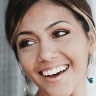

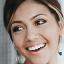

In [3]:
# Check the resize_data

from IPython import display
from random import choice
import os

img_list = os.listdir(raw_data)
id = choice(img_list)
display.display(display.Image(raw_data + id))
display.display(display.Image(resize_data + id))

In [4]:
# Setting Data Loader

import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

img_size = 64
batch_size = 128
data_dir = resize_data + '..'

transform = transforms.Compose([
#         transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

dset = datasets.ImageFolder(data_dir, transform)
train_loader = torch.utils.data.DataLoader(dset, batch_size = batch_size, shuffle=True,
                                          drop_last = False)
temp = plt.imread(train_loader.dataset.imgs[0][0])

In [5]:
# Set up Generator and Discriminator

import torch.nn as nn

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        
        return x
    
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [6]:
# Compile Model

import torch.optim as optim

CUDA = -1
device = torch.device(f'{CUDA}' if ( torch.cuda.is_available() and CUDA >= 0 ) else 'cpu')

G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.to(device)
D.to(device)

BCE_loss = nn.BCELoss()

G_optimizer = optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))

In [ ]:
# Training

from tqdm import tqdm
from torch.autograd import Variable
import torch.nn.functional as F

train_epochs = 2
mini_batch = batch_size

for epoch in range(train_epochs):
    D_losses = []
    G_losses = []
    
    for iteration, (x_, x) in enumerate(tqdm(train_loader)):
        ## Train Generator
        G.zero_grad()
        
        # Set input
        noise = torch.normal(0, 1, (mini_batch, 100)).view(-1, 100, 1, 1)
        noise = Variable(noise.to(device))
        y_real_ = torch.ones(mini_batch)
        y_real_ = Variable(y_real_.to(device))

        # Forward
        G_result = G(noise)
        D_result = D(G_result).squeeze()
        
        # Backeard
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        
        ## Train Discriminator
        D.zero_grad()
        
        # Set input
        x_ = Variable(x_.to(device))
        noise = torch.normal(0, 1, (mini_batch, 100)).view(-1, 100, 1, 1)
        noise = Variable(noise.to(device))
        y_real_ = torch.ones(x_.size()[0])
        y_real_ = Variable(y_real_.to(device))
        y_fake_ = torch.zeros(mini_batch)
        y_fake_ = Variable(y_fake_.to(device))

        # Forward
        D_real_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_real_result, y_real_)
        
        # Backward
        G_result = G(noise)
        D_fake_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_fake_result, y_fake_)
        D_fake_score = D_fake_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()
        
        ## History
        G_losses.append(G_train_loss.data)
        D_losses.append(D_train_loss.data)
        
    ## result
    print ('Epoch[{}/{}] d_loss:{} | g_loss:{}'.format(epoch+1,train_epochs,
                                            torch.mean(torch.FloatTensor(D_losses)),
                                            torch.mean(torch.FloatTensor(G_losses))),end='')

In [8]:
# Save Model
name = 'DCGAN(1)'
os.makedirs(f'./output/log/{name}', exist_ok= True)
torch.save(G.state_dict(),f"./output/log/{name}/generator_param.pkl")
torch.save(D.state_dict(),f"./output/log/{name}/discriminator_param.pkl")

In [9]:
# Load Model
G.load_state_dict(torch.load(f"./output/log/{name}/generator_param.pkl"))
D.load_state_dict(torch.load(f"./output/log/{name}/discriminator_param.pkl"))

<All keys matched successfully>

<ipython-input-10-802831874a6d>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  noise = Variable(noise.to(device), volatile=True)


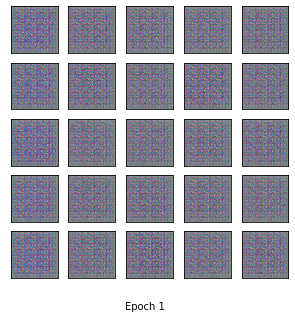

In [10]:
# Output Image

import itertools
import matplotlib.pyplot as plt

def generate_5x5_face(noise, model_name, epoch = -1):
    noise = Variable(noise.to(device), volatile=True)
    test_images = G(noise)

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    if epoch != -1:
        label = 'Epoch {0}'.format(epoch)
        fig.text(0.5, 0.04, label, ha='center')
        plt.savefig(f'./output/log/{model_name}/generate_image/image[{epoch}]')

    plt.show()

os.makedirs(f'./output/log/{name}/generate_image', exist_ok= True)
noise = torch.normal(0, 1, (5*5, 100)).view(-1, 100, 1, 1) 
generate_5x5_face(noise, name, epoch = 1)

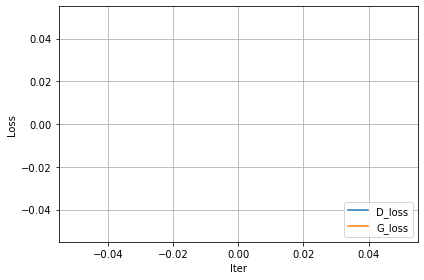

<Figure size 432x288 with 0 Axes>

In [11]:
# Show Train History

def show_history(G_losses, D_losses, model_name):
    x = range(len(G_losses))

    plt.plot(x, G_losses, label='D_loss')
    plt.plot(x, D_losses, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    plt.savefig(f'./output/log/{model_name}/history.png')
                
show_history(G_losses, D_losses, name)